## Entfernen von Straßentyp "service" 
-----

Wir möchten unser Model auch mit einem Datensatz trainieren in dem der Straßentyp service nicht enthalten ist und die Auswirkunge betrachten.  
Deshalb erstellen wir auch einen Datensatz ohne highway=service

Wir beutzen den vorbereiteten Datensatz cycle_net_berlin_cleaned, der keine leere Geometrien mehr enthält und nur Straßen innerhalb Berlins ausgibt.


In [4]:
import geopandas as gpd

# Pfad zur GeoJSON-Datei
file_path = "../../data/cycle_net_berlin_cleaned.geojson"

# Laden der GeoJSON-Datei
berlin_cyclenet = gpd.read_file(file_path)

### Bereinigung der Daten

Es erfolgt keine Analyse der Daten mehr, denn das ist bereits in diesem notbook geschehen: [osm_maxspeed](osm_maxspeed.ipynb) 

#### Setzen fehlender Werte

In [7]:
import pandas as pd

# Definiere die Standardwerte für 'maxspeed' basierend auf dem 'highway'-Typ
default_speeds = {
    "service": 20,
    "path": 20,
    "cycleway": 20,
    "footway": 5,
    "track": 20,
    "living_street": 10,
    "primary": 50,
    "secondary": 50,
    "tertiary": 50,
    "residential": 30
}

# Funktion zum Zuweisen von 'maxspeed'-Werten basierend auf dem 'highway'-Typ
def assign_maxspeed(row):
    if pd.isna(row['maxspeed']):
        return default_speeds.get(row['highway'], 5)
    return row['maxspeed']

# Wende die Funktion auf die GeoDataFrame an
berlin_cyclenet['maxspeed'] = berlin_cyclenet.apply(assign_maxspeed, axis=1)




#### Überprüfung ob noch fehlende Werte bei maxspeed vorhanden

In [8]:
# Zähle die Vorkommen jedes Wertes in der Spalte 'maxspeed'
maxspeed_counts = berlin_cyclenet['maxspeed'].value_counts(dropna=False).reset_index()
maxspeed_counts.columns = ['Maxspeed', 'Anzahl Strassen']

# Ersetzen von NaN durch "No Data"
maxspeed_counts['Maxspeed'] = maxspeed_counts['Maxspeed'].fillna('No Data')


# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = maxspeed_counts['Anzahl Strassen'].sum()

# Anzahl der Straßen ohne maxspeede-Wert (NaN)
anzahl_no_data = maxspeed_counts[maxspeed_counts['Maxspeed'].isna()]['Anzahl Strassen'].sum()

# Falls wir 'No Data' als Text haben statt NaN
anzahl_no_data += maxspeed_counts[maxspeed_counts['Maxspeed'] == 'No Data']['Anzahl Strassen'].sum()

# Prozentsatz berechnen
prozent_no_data = (anzahl_no_data / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'maxspeed'-Wert ist: {anzahl_no_data}")
print(f"Prozentualer Anteil der Straßen ohne 'maxspeed'-Wert: {prozent_no_data:.2f}%")

Die Gesamtzahl der Straßen ist: 167881
Die Anzahl der Straßen ohne 'maxspeed'-Wert ist: 0
Prozentualer Anteil der Straßen ohne 'maxspeed'-Wert: 0.00%


#### maxspeed Werte in Kategorien zusammenfassen

In [9]:
def categorize_maxspeed(value):
    try:
        original_value = value
        value = float(str(value).strip().lower().replace(' mph', '').replace('walk', '5').replace('5 mph', '5'))
    except ValueError:
        print(f"Unkategorisierter Wert: {original_value}")
        return 'No Data'
    
    if value == 70 or value == 80:
        return '70'
    elif value == 60:
        return '60'
    elif value == 50 or value == 40:
        return '50'
    elif value == 30:
        return '30'
    elif value == 20 or value == 17 or value == 15:
        return '20'
    elif value == 10 or value == 8 or value == 100:
        return '10'
    elif value == 6 or value == 7 or value == 5:
        return '5'
    else:
        return 'Other'


# Kategorisieren der maxspeed-Werte
berlin_cyclenet['maxspeed_category'] = berlin_cyclenet['maxspeed'].apply(categorize_maxspeed)

# Zählen der Vorkommen jeder Kategorie
maxspeed_category_counts = berlin_cyclenet['maxspeed_category'].value_counts().reset_index()
maxspeed_category_counts.columns = ['Maxspeed Kategorie', 'Anzahl Strassen']

print(maxspeed_category_counts)

  Maxspeed Kategorie  Anzahl Strassen
0                 20           102081
1                 30            33268
2                 50            20246
3                  5             7724
4                 10             4218
5                 60              303
6                 70               41


### Entfernen des Straßentyps "service"
---

query: Verwendet eine Zeichenkette zur Angabe der Bedingung. cycle_net_berlin.query("highway != 'service'") gibt nur die Zeilen zurück, bei denen der Wert in der Spalte highway nicht service ist.

In [10]:
import geopandas as gpd


# Entfernen von Straßen vom Typ 'service'
berlin_cyclenet_noservice = berlin_cyclenet.query("highway != 'service'")

#### Überprüfen ob service entfernt wurde

In [11]:
unique_highway_types = berlin_cyclenet_noservice['highway'].unique()

print("Vorhandene Straßentypen bei 'highway':")
print(unique_highway_types)

Vorhandene Straßentypen bei 'highway':
['residential' 'primary' 'secondary' 'living_street' 'tertiary'
 'unclassified' 'trunk' 'path' 'footway' 'secondary_link' 'cycleway'
 'track' 'pedestrian' 'primary_link' 'tertiary_link' 'construction'
 'steps' 'bridleway' 'busway' 'elevator' 'proposed' 'road' 'street_lamp'
 'services' 'rest_area' 'bus_stop']


### Minimieren des Datensatzes auf relevante Spalten

für die weitere Verarbeitung wollen wir nur die Spalten "geometry" und die neu generierte Spalte "maxspeed_category" behalten.

In [12]:
# Extrahieren der relevanten Spalten 
maxspeeds = berlin_cyclenet_noservice[['geometry', 'maxspeed_category']]

In [17]:
maxspeeds.shape

(80476, 2)

### Speichern des bereinigten Datensatzes
---

In [13]:
# Speichern der bereinigten Daten
output_file_name = "../../data/processed_data/cycle_net_berlin_cleaned_maxspeed_noservice.geojson"
maxspeeds.to_file(output_file_name, driver="GeoJSON")
print(f"Datei erfolgreich als GeoJSON gespeichert unter: {output_file_name}")

Datei erfolgreich als GeoJSON gespeichert unter: ../../data/processed_data/cycle_net_berlin_cleaned_maxspeed_noservice.geojson


### Überprüfung des gespeichterten Datensatzes
---

In [14]:
osm_maxspeed = gpd.read_file("../../data/processed_data/cycle_net_berlin_cleaned_maxspeed.geojson")

In [15]:
osm_maxspeed.head()

,maxspeed_category,geometry
0,30,"MULTILINESTRING ((13.53136 52.49263, 13.53136 ..."
1,30,"MULTILINESTRING ((13.52694 52.48969, 13.52639 ..."
2,30,"MULTILINESTRING ((13.52477 52.48558, 13.52484 ..."
3,50,"MULTILINESTRING ((13.45420 52.51571, 13.45431 ..."
4,30,"MULTILINESTRING ((13.37261 52.59296, 13.37347 ..."


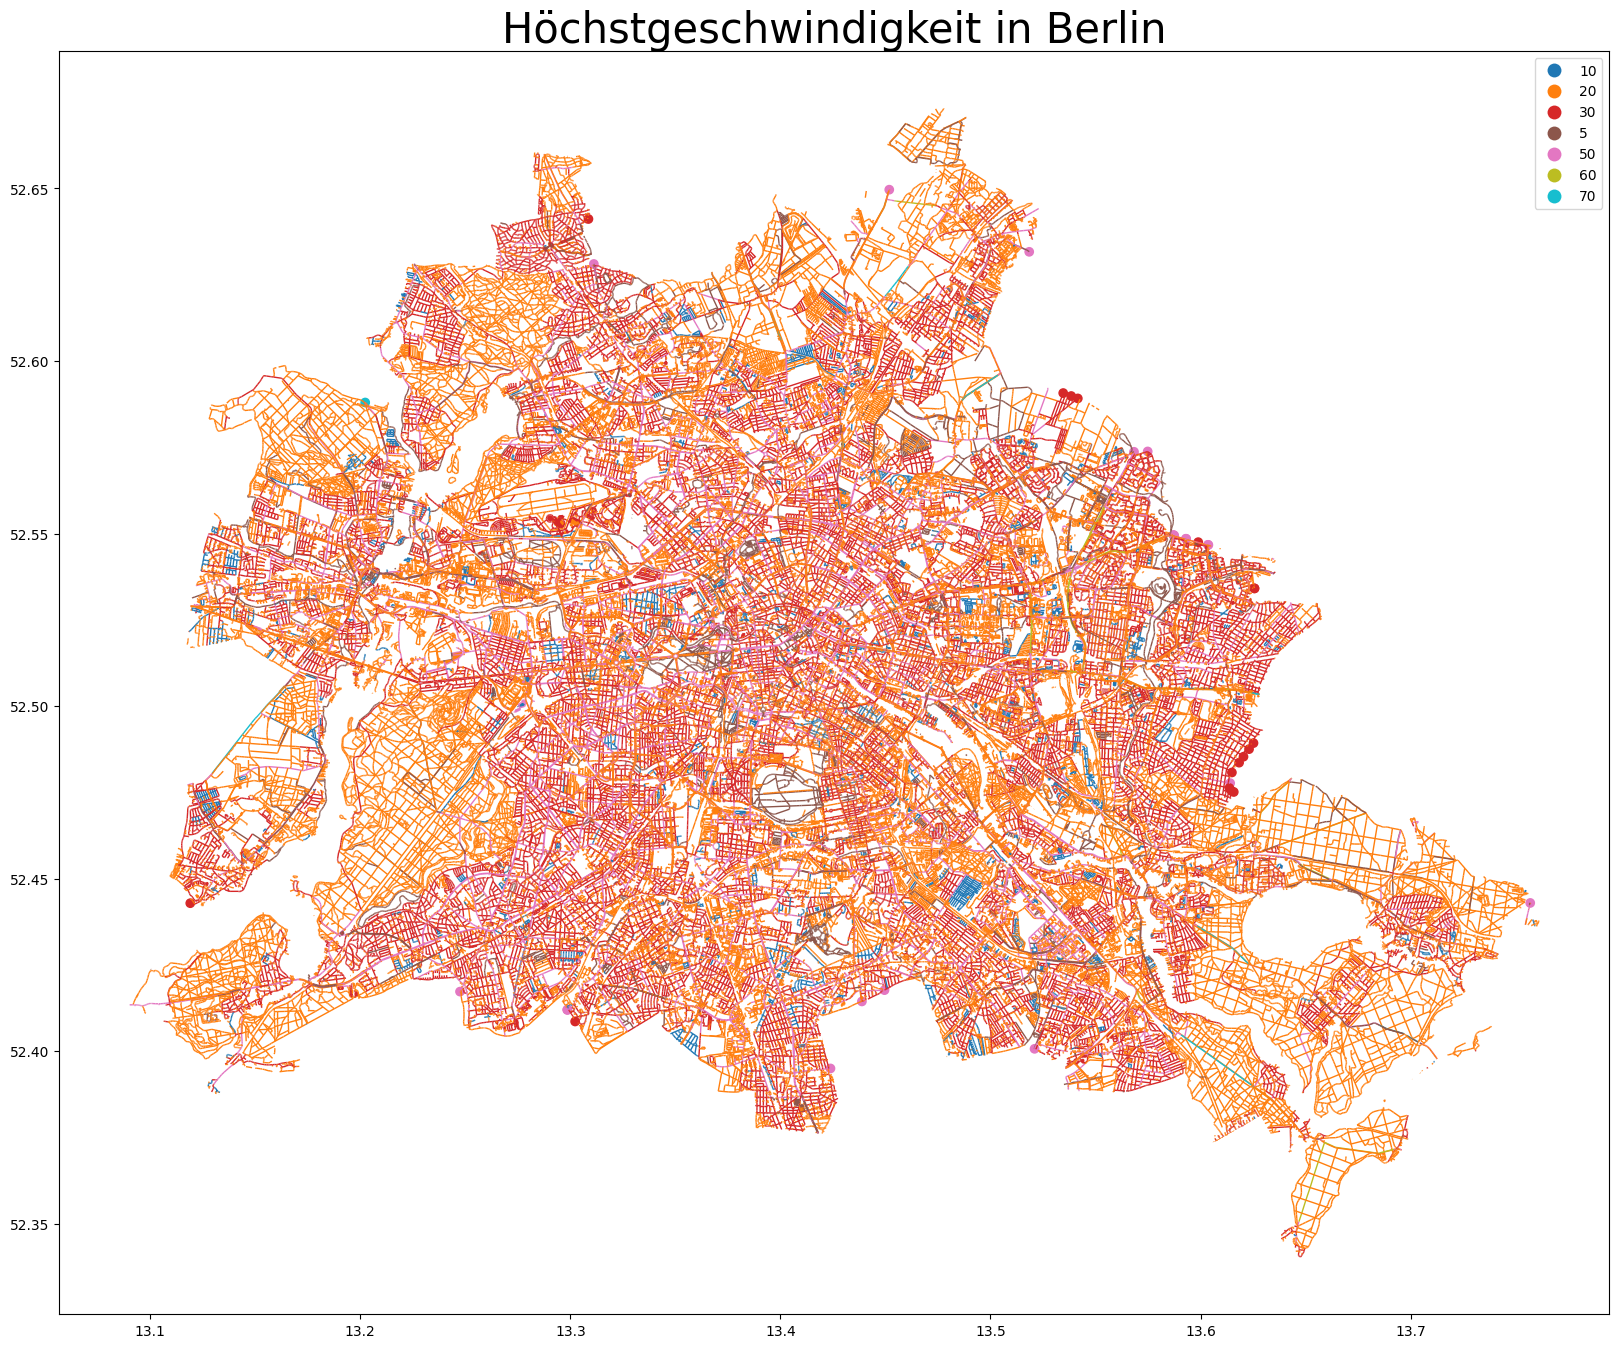

In [16]:
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
import geopandas as gpd
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# Verwenden des 'tab20' Farbkarte, um bis zu 20 verschiedene Farben zu unterscheiden
base = osm_maxspeed.plot(column='maxspeed_category', ax=ax, legend=True,
                             cmap='tab10', linewidth=1, legend_kwds={'bbox_to_anchor': (1, 1)})

plt.title("Höchstgeschwindigkeit in Berlin", fontsize=30)
plt.show()